In [1]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data, metallicity_profile, metals_profile, gasmetals_profile, metals_density_profile, metals_particle_profile, get_insitu, histmetals_density_profile, halfmass_rad_stars, stellar_density, gasmetals_density_profile, effective_yield, stellar_gas_densities, gasmetals_only, stellar_gas_metallicities, gas_mass, bimodal_check, starmetals_only, stellar_mass, get_stellar_age, gas_consumption

redshift = 4

In [2]:
with h5py.File('galaxy_population_data_'+str(redshift)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
#     halflight_radius_U = f['halflight_radius_U'][:]
#     halflight_radius_V = f['halflight_radius_V'][:]
#     halflight_radius_I = f['halflight_radius_I'][:]
    newbin_current_SFR = f['newbin_current_SFR'][:]
#     maximum_merger_ratio_30kpc_current_fraction = f['maximum_merger_ratio_30kpc_current_fraction'][:]
#     FeH_Re = f['FeH_Re'][:]
#     MgFe_Re = f['MgFe_Re'][:]
#     MgH_Re = f['MgH_Re'][:]
#     FeH_1kpc = f['FeH_1kpc'][:]
#     MgFe_1kpc = f['MgFe_1kpc'][:]
#     MgH_1kpc = f['MgH_1kpc'][:]
    gas_mass_1kpc = f['gas_mass_1kpc'][:]
    stellar_mass_1kpc = f['stellar_mass_1kpc'][:]
#     OH_Re = f['OH_Re']
#     OH_1kpc = f['OH_1kpc']
#     OFe_Re = f['OFe_Re']
#     OFe_1kpc = f['OFe_1kpc']
#     FeH_gas_Re = f['FeH_gas_Re']
#     FeH_gas_1kpc = f['FeH_gas_1kpc']
#     OH_gas_Re = f['FeH_gas_Re']
#     OH_gas_1kpc = f['FeH_gas_1kpc']

In [3]:
import warnings
warnings.filterwarnings('ignore')

# PSB_selection = (median_age<=1.2)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# intermediate_quiescent_selection = (median_age>1.2)&(median_age<=1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# old_quiescent_selection = (median_age>1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# starforming_selection = (np.log10(newbin_current_SFR/10**(total_mass))>-10.5)
# quiescent_selection = (np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# starforming_selection = (gas_mass_1kpc/stellar_mass_1kpc>0.025)
# quiescent_selection = (gas_mass_1kpc/stellar_mass_1kpc<0.025)
starforming_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))>-1.75)
quiescent_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))<=-1.75)

# selection criteria

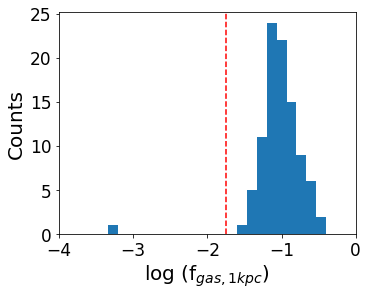

In [17]:
fig = plt.figure(1,figsize=(5,4), constrained_layout=True)
fig.clf()
fts = 20

big_hist = np.log10(gas_mass_1kpc / (gas_mass_1kpc + stellar_mass_1kpc))
# np.nan_to_num(big_hist, copy=False, nan=0.0, neginf=0.0)
big_hist[big_hist<-4] = -3.9
# print(big_hist)
plt.hist(big_hist, bins=30, range=(-4, 0.0), density=False)
plt.axvline(x=-1.75, linestyle='--', color='r')
plt.xlabel('log (f$_{gas, 1kpc}$)', fontsize=fts)
plt.ylabel('Counts', fontsize=fts)
plt.tick_params(labelsize=fts-3)
plt.xlim(-4, 0)

# plt.savefig('2022 FIGURES/bimodal.png', dpi=400)

plt.show()

# yeff stuff

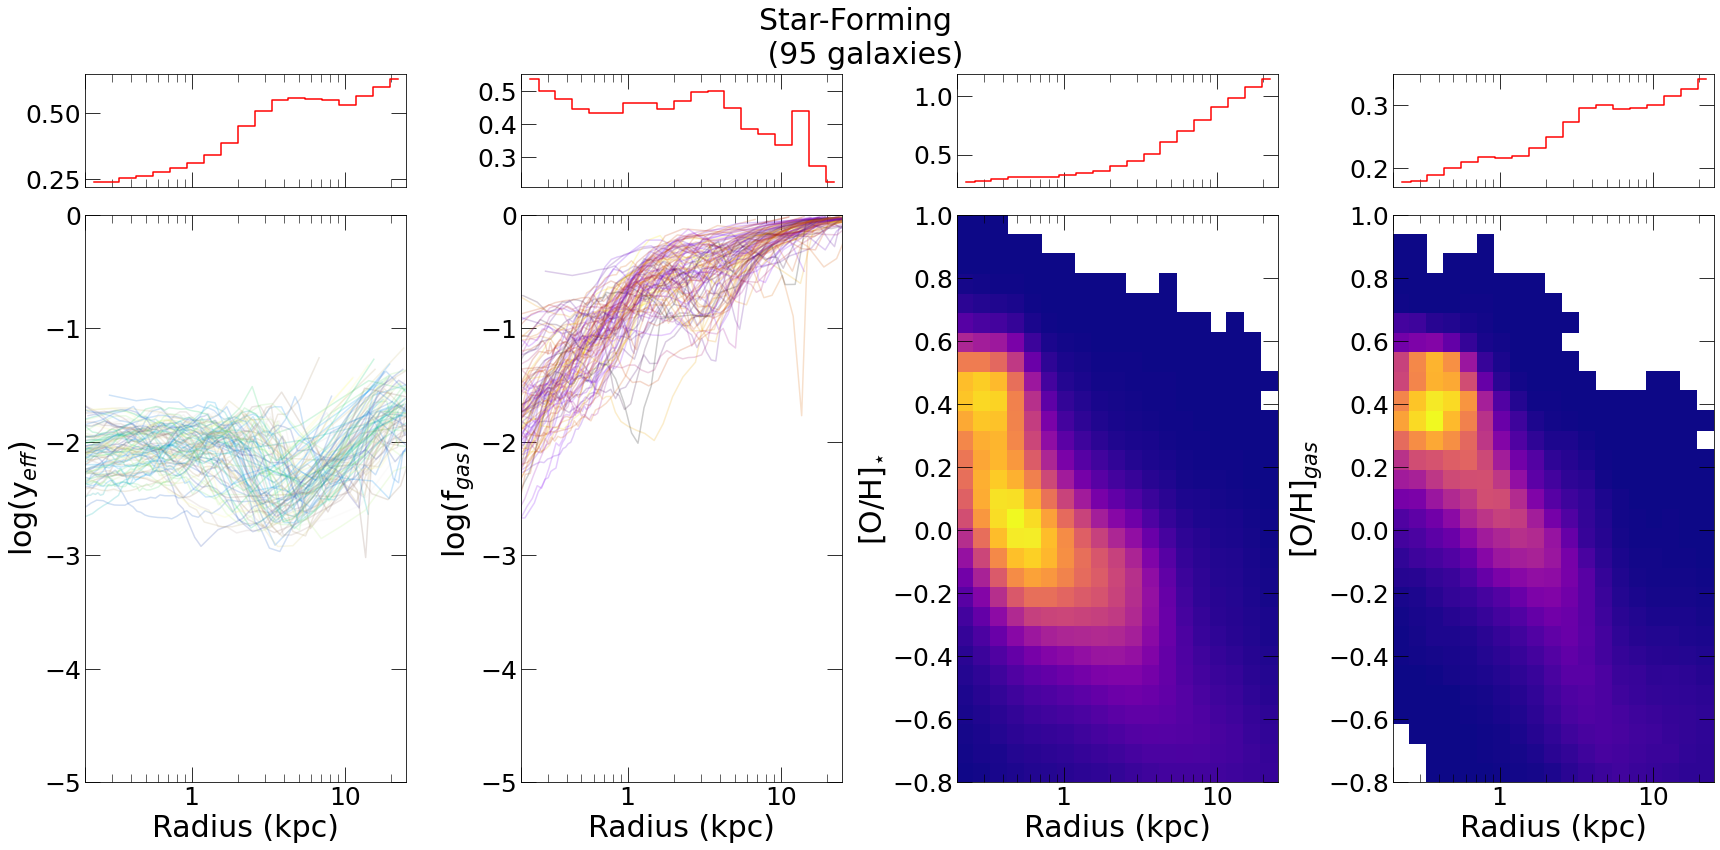

In [4]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange

#metallicity profiles
f, (axes) = plt.subplots(2, 4, sharex='none', sharey='none', figsize=(24, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
ax4 = axes[1][3]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]
sc4 = axes[0][3]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap1 = plt.get_cmap('terrain')
colormap2 = plt.get_cmap('gnuplot')
norm = colors.Normalize(vmin=0, vmax=30)
colormap = plt.get_cmap('plasma')
norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-0.8, 1, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_star = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in ids[starforming_selection]:
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        OH_star = starmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen')
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
#         R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
        big_R = np.concatenate((big_R, R), axis=None)
        big_R_star = np.concatenate((big_R_star, R_star), axis=None)
        big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
        big_OH_star = np.concatenate((big_OH_star, OH_star), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
        h3, _, _ = np.histogram2d(R_star, OH_star, bins=[xbins, metalbins], density=False)
        big_h3 += h3
        h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
        big_h4 += h4

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R_star, np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
        xx = percentiles[:-1]
        
        number = randrange(30)
        color1 = colormap1(norm(number))
#         color1 = tuple(color1[0][:])
        color2 = colormap2(norm(number))
#         color2 = tuple(color2[0][:])
        ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_star, big_OH_star, 'std', bins=xbins)
stat4, _, _ = stats.binned_statistic(big_R_star, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')
sc4.step(xbins_new, stat4, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-5, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm_plasma(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 25)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10], minor=False)
    ax[2].set_xticklabels(['', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{\star}$', fontsize=fts)
ax3.set_ylim(-0.8, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

big_h4[big_h4==0] = np.nan
color=colormap(norm_plasma(big_h4)).tolist()
color = tuple(color[0][:])
ax4.pcolormesh(xbins, metalbins, big_h4.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[3].set_xlim(0.2, 25)
    ax[3].set_xscale('log')
    ax[3].set_xticks([0.2, 1, 10], minor=False)
    ax[3].set_xticklabels(['', '1', '10'])
    ax[3].tick_params(which='major', length=15)
    ax[3].tick_params(which='minor', length=8)
    ax[3].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel("Radius (kpc)", fontsize=fts)
ax4.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax4.set_ylim(-0.8, 1)

f.suptitle('Star-Forming \n (' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff.png', dpi=100)

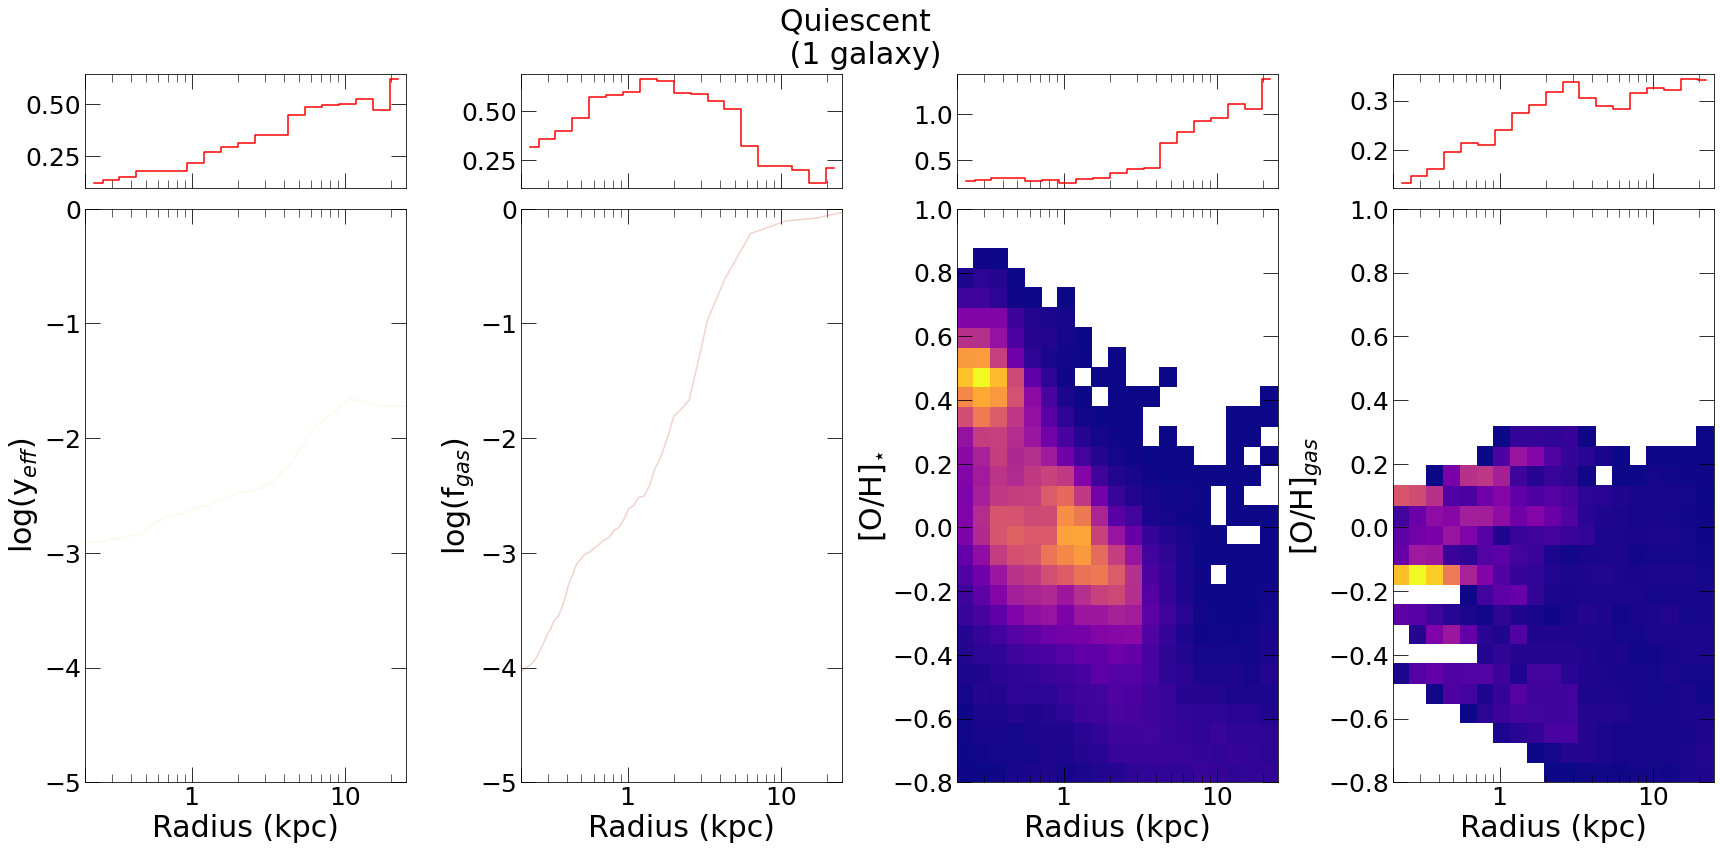

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange

#metallicity profiles
f, (axes) = plt.subplots(2, 4, sharex='none', sharey='none', figsize=(24, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
ax4 = axes[1][3]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]
sc4 = axes[0][3]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap1 = plt.get_cmap('terrain')
colormap2 = plt.get_cmap('gnuplot')
norm = colors.Normalize(vmin=0, vmax=30)
colormap = plt.get_cmap('plasma')
norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-0.8, 1, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_y_eff = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_star = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in ids[quiescent_selection]:
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        OH_star = starmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen')
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
#         R_e = halfmass_rad_stars(id, redshift)
        big_y_eff = np.concatenate((big_y_eff, np.log10(y_eff)), axis=None)
        big_R = np.concatenate((big_R, R), axis=None)
        big_R_star = np.concatenate((big_R_star, R_star), axis=None)
        big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
        big_OH_star = np.concatenate((big_OH_star, OH_star), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
        h3, _, _ = np.histogram2d(R_star, OH_star, bins=[xbins, metalbins], density=False)
        big_h3 += h3
        h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
        big_h4 += h4

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R_star, np.log10(y_eff), 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
        xx = percentiles[:-1]
        
        number = randrange(30)
        color1 = colormap1(norm(number))
#         color1 = tuple(color1[0][:])
        color2 = colormap2(norm(number))
#         color2 = tuple(color2[0][:])
        ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_y_eff, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_star, big_OH_star, 'std', bins=xbins)
stat4, _, _ = stats.binned_statistic(big_R_star, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')
sc4.step(xbins_new, stat4, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(-5, 0)
# ax1.set_yscale('log')
ax1.set_ylabel("log(y$_{eff}$)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm_plasma(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 25)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10], minor=False)
    ax[2].set_xticklabels(['', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{\star}$', fontsize=fts)
ax3.set_ylim(-0.8, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

big_h4[big_h4==0] = np.nan
color=colormap(norm_plasma(big_h4)).tolist()
color = tuple(color[0][:])
ax4.pcolormesh(xbins, metalbins, big_h4.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[3].set_xlim(0.2, 25)
    ax[3].set_xscale('log')
    ax[3].set_xticks([0.2, 1, 10], minor=False)
    ax[3].set_xticklabels(['', '1', '10'])
    ax[3].tick_params(which='major', length=15)
    ax[3].tick_params(which='minor', length=8)
    ax[3].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel("Radius (kpc)", fontsize=fts)
ax4.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax4.set_ylim(-0.8, 1)

f.suptitle('Quiescent \n (' + str(len(ids[quiescent_selection])) + ' galaxy)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff_quiescent.png', dpi=100)

# S(Z)

[0, 1] 0.03102098133930936 0.3200051486492157
[3, 4] 0.2738337503767721 -0.33192160725593567
[5, 6] 0.3099147401662466 -0.5708692371845245
[10, 11] 0.5714640793896294 -0.6850342154502869


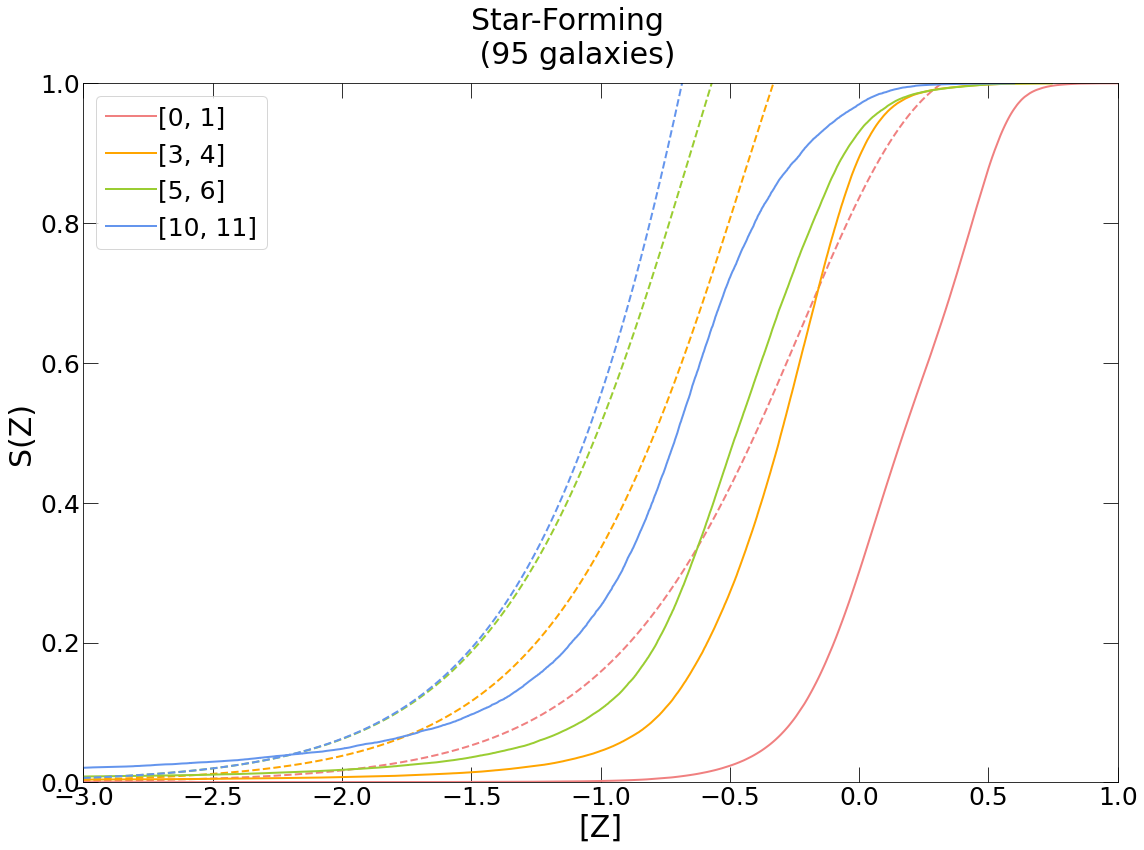

In [9]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange
from dataclasses import dataclass

#metallicity profiles
f, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(16, 12), constrained_layout=True)

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap1 = plt.get_cmap('terrain')
# colormap2 = plt.get_cmap('gnuplot')
# norm = colors.Normalize(vmin=0, vmax=30)
# colormap = plt.get_cmap('plasma')
# norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
# ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
# metalbins = np.linspace(-0.8, 1, 30)
# densitybins2 = np.linspace(1.5, 12, 20)

@dataclass
class CDF:
#     selection: np.ndarray
    label: str
    color: str
    big_R_star: np.array = np.zeros(0)
    big_f_gas: np.array = np.zeros(0)
    big_OH_star: np.array = np.zeros(0)
    big_OH_gas: np.array = np.zeros(0)
            
ranges = [CDF(label='[0, 1]', color='lightcoral'), CDF(label='[3, 4]', color='orange'), CDF(label='[5, 6]', color='yellowgreen'), CDF(label='[10, 11]', color='cornflowerblue')]

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
# big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
# big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
# big_y_eff = np.zeros(0)
# big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_star = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in ids[starforming_selection]:
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
#         w = np.where(5<=R_star&R_star<=6)
        OH_star = starmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen')
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
        selection = [(R_star<=1), (3<=R_star)&(R_star<=4), (5<=R_star)&(R_star<=6), (10<=R_star)&(R_star<=11)]
#         rad5_6 = (5<=R_star)&(R_star<=6)
#         rad3_4 = (3<=R_star)&(R_star<=4)
        for i in range(len(selection)):
            radii = ranges[i]
            criteria = selection[i]
            OH_star_new = OH_star[criteria]
            f_gas_new = f_gas[criteria]
#             y_eff_new = y_eff[radii.selection]
            OH_gas_new = OH_gas[criteria]
    #         R_e = halfmass_rad_stars(id, redshift)
    #         big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    #         big_R = np.concatenate((big_R, R), axis=None)
#             radii.big_R_star = np.concatenate((radii.big_R_star, R_star_new), axis=None)
            radii.big_f_gas = np.concatenate((radii.big_f_gas, f_gas_new), axis=None)
            radii.big_OH_star = np.concatenate((radii.big_OH_star, OH_star_new), axis=None)
            radii.big_OH_gas = np.concatenate((radii.big_OH_gas, OH_gas_new), axis=None)
#         h3, _, _ = np.histogram2d(R_star, OH_star, bins=[xbins, metalbins], density=False)
#         big_h3 += h3
#         h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
#         big_h4 += h4

        # calculate statistic for profile
#         n_bins = 50
#         percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
#         for i in range(1, (n_bins+1)):
#             percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
#         percentiles.sort()
#         stat1, _, _ = scipy.stats.binned_statistic(R_star, np.log10(y_eff), 'median', bins=percentiles)
#         stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
#         xx = percentiles[:-1]
        
#         number = randrange(30)
#         color1 = colormap1(norm(number))
#         color1 = tuple(color1[0][:])
#         color2 = colormap2(norm(number))
#         color2 = tuple(color2[0][:])
#         ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
#         ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)

for radii in ranges:
    # CDF
    xx1 = np.sort(radii.big_OH_star)
    yy1 = np.array(range(len(radii.big_OH_star)))/len(radii.big_OH_star)
    ax1.plot(xx1, yy1, '-', label=radii.label, linewidth=2, color=radii.color)

    # model
    xx2 = radii.big_OH_star
    med_f_gas = np.median(radii.big_f_gas)
    med_OH_gas = np.median(radii.big_OH_gas)
    print(radii.label, med_f_gas, med_OH_gas)
    yy2 = (1 - med_f_gas**(10**(radii.big_OH_star-med_OH_gas))) / (1 - med_f_gas)
    # yy2 = (1 - 0.3**(10**(big_OH_star-0.5))) / (1 - 0.3)
    yy2_plot = [yy2 for _, yy2 in sorted(zip(xx2, yy2))]
    ax1.plot(np.sort(xx2), yy2_plot, '--', linewidth=2, color=radii.color)

ax1.set_xlim(-3, 1)
#     ax1.set_xticks([0.2, 1, 10], minor=False)
#     ax1.set_xticklabels(['', '1', '10'])
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 1)
# ax1.set_yscale('log')
ax1.set_ylabel("S(Z)", fontsize=fts)
ax1.set_xlabel('[Z]', fontsize=fts)
ax1.legend(fontsize=ftss, handletextpad=0.1)


f.suptitle('Star-Forming \n (' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff.png', dpi=100)

[0, 1] 0.0002351605795865891 -0.07543056458234787
[3, 4] 0.0716740110367387 -0.17625129222869873
[5, 6] 0.2745073967670859 -0.28040896356105804
[10, 11] 0.7194228817838106 -0.2689369022846222


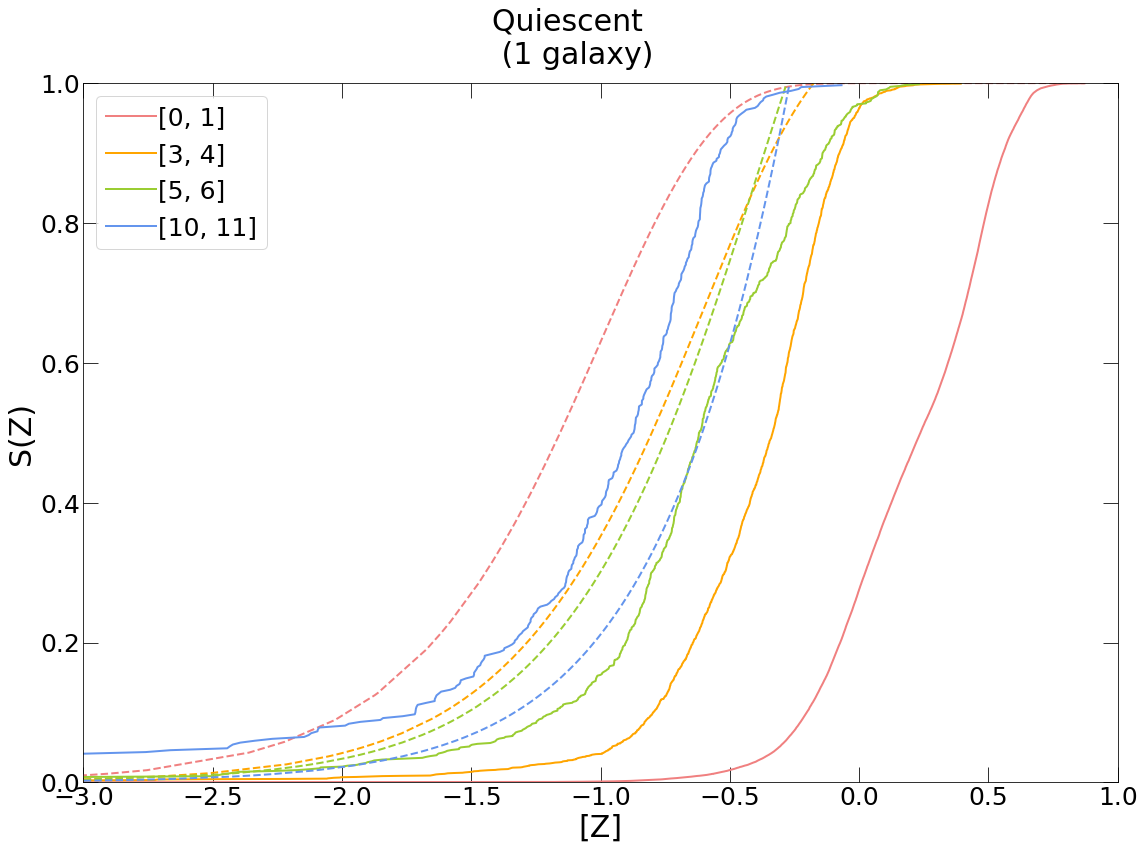

In [11]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange
from dataclasses import dataclass

#metallicity profiles
f, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(16, 12), constrained_layout=True)

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

# colormap1 = plt.get_cmap('terrain')
# colormap2 = plt.get_cmap('gnuplot')
# norm = colors.Normalize(vmin=0, vmax=30)
# colormap = plt.get_cmap('plasma')
# norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
# xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
# ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
# metalbins = np.linspace(-0.8, 1, 30)
# densitybins2 = np.linspace(1.5, 12, 20)

@dataclass
class CDF:
#     selection: np.ndarray
    label: str
    color: str
    big_R_star: np.array = np.zeros(0)
    big_f_gas: np.array = np.zeros(0)
    big_OH_star: np.array = np.zeros(0)
    big_OH_gas: np.array = np.zeros(0)
            
ranges = [CDF(label='[0, 1]', color='lightcoral'), CDF(label='[3, 4]', color='orange'), CDF(label='[5, 6]', color='yellowgreen'), CDF(label='[10, 11]', color='cornflowerblue')]

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
# big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
# big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
# big_y_eff = np.zeros(0)
# big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_star = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in ids[quiescent_selection]:
    R, f_gas, y_eff, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
#         w = np.where(5<=R_star&R_star<=6)
        OH_star = starmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen')
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
        selection = [(R_star<=1), (3<=R_star)&(R_star<=4), (5<=R_star)&(R_star<=6), (10<=R_star)&(R_star<=11)]
#         rad5_6 = (5<=R_star)&(R_star<=6)
#         rad3_4 = (3<=R_star)&(R_star<=4)
        for i in range(len(selection)):
            radii = ranges[i]
            criteria = selection[i]
            OH_star_new = OH_star[criteria]
            f_gas_new = f_gas[criteria]
#             y_eff_new = y_eff[radii.selection]
            OH_gas_new = OH_gas[criteria]
    #         R_e = halfmass_rad_stars(id, redshift)
    #         big_y_eff = np.concatenate((big_y_eff, y_eff), axis=None)
    #         big_R = np.concatenate((big_R, R), axis=None)
#             radii.big_R_star = np.concatenate((radii.big_R_star, R_star_new), axis=None)
            radii.big_f_gas = np.concatenate((radii.big_f_gas, f_gas_new), axis=None)
            radii.big_OH_star = np.concatenate((radii.big_OH_star, OH_star_new), axis=None)
            radii.big_OH_gas = np.concatenate((radii.big_OH_gas, OH_gas_new), axis=None)
#         h3, _, _ = np.histogram2d(R_star, OH_star, bins=[xbins, metalbins], density=False)
#         big_h3 += h3
#         h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
#         big_h4 += h4

        # calculate statistic for profile
#         n_bins = 50
#         percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
#         for i in range(1, (n_bins+1)):
#             percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
#         percentiles.sort()
#         stat1, _, _ = scipy.stats.binned_statistic(R_star, np.log10(y_eff), 'median', bins=percentiles)
#         stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
#         xx = percentiles[:-1]
        
#         number = randrange(30)
#         color1 = colormap1(norm(number))
#         color1 = tuple(color1[0][:])
#         color2 = colormap2(norm(number))
#         color2 = tuple(color2[0][:])
#         ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
#         ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)

for radii in ranges:
    # CDF
    xx1 = np.sort(radii.big_OH_star)
    yy1 = np.array(range(len(radii.big_OH_star)))/len(radii.big_OH_star)
    ax1.plot(xx1, yy1, '-', label=radii.label, linewidth=2, color=radii.color)

    # model
    xx2 = radii.big_OH_star
    med_f_gas = np.median(radii.big_f_gas)
    med_OH_gas = np.median(radii.big_OH_gas)
    print(radii.label, med_f_gas, med_OH_gas)
    yy2 = (1 - med_f_gas**(10**(radii.big_OH_star-med_OH_gas))) / (1 - med_f_gas)
    # yy2 = (1 - 0.3**(10**(big_OH_star-0.5))) / (1 - 0.3)
    yy2_plot = [yy2 for _, yy2 in sorted(zip(xx2, yy2))]
    ax1.plot(np.sort(xx2), yy2_plot, '--', linewidth=2, color=radii.color)

ax1.set_xlim(-3, 1)
#     ax1.set_xticks([0.2, 1, 10], minor=False)
#     ax1.set_xticklabels(['', '1', '10'])
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 1)
# ax1.set_yscale('log')
ax1.set_ylabel("S(Z)", fontsize=fts)
ax1.set_xlabel('[Z]', fontsize=fts)
ax1.legend(fontsize=ftss, handletextpad=0.1)


f.suptitle('Quiescent \n (' + str(len(ids[quiescent_selection])) + ' galaxy)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

# for ax in axes[0]:
#     ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff.png', dpi=100)

# profiles

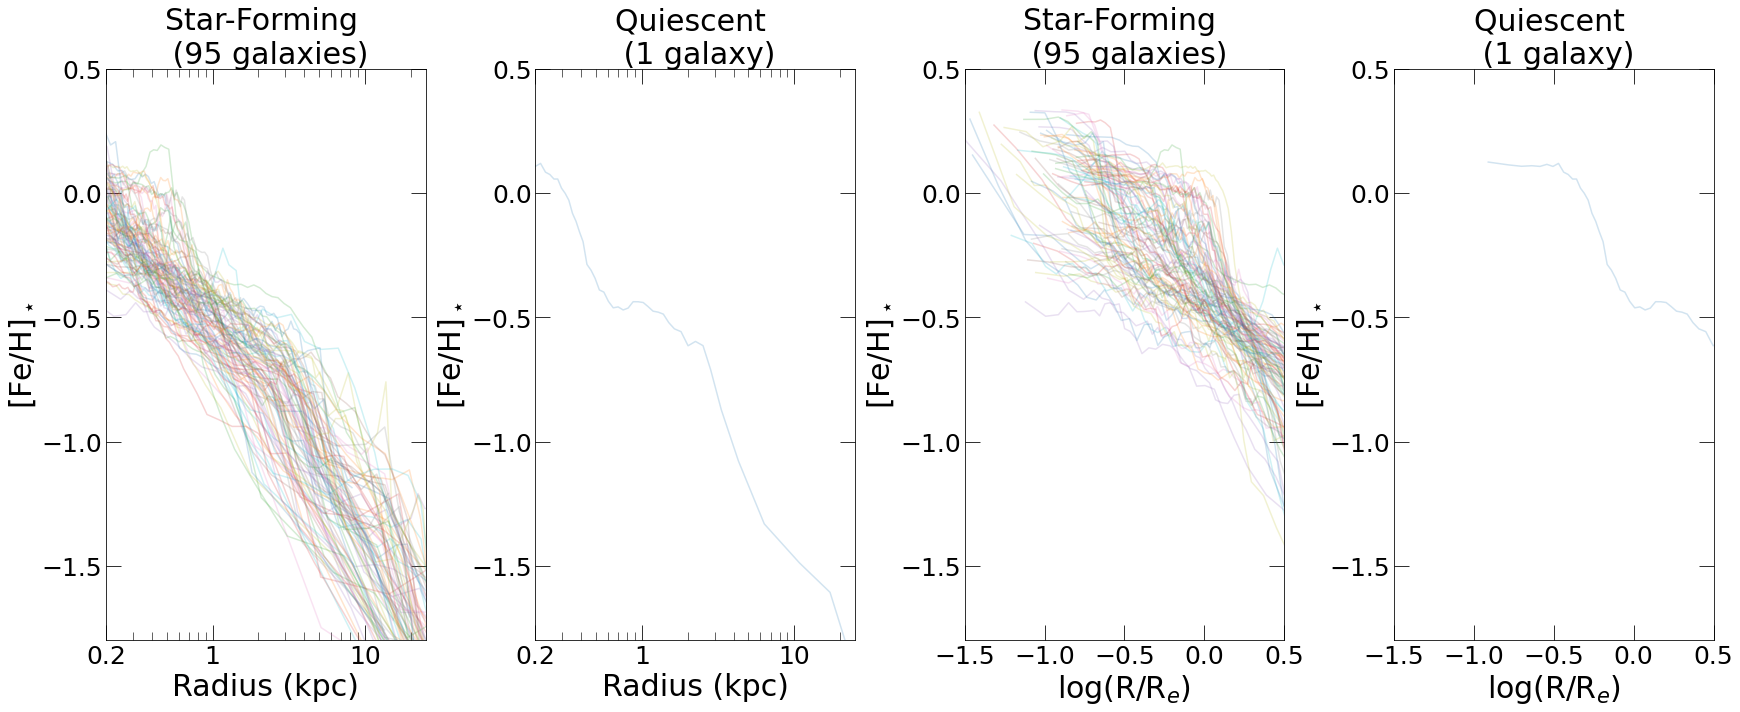

In [12]:
#metallicity profiles
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='none', sharey='none', figsize=(24, 10))
f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25

#z=2 star-forming galaxies
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[starforming_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax1.plot(xx, yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
# radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
ax1.set_xlim(0.2, 25)
ax1.set_ylim(-1.8, 0.5)
ax1.set_xlabel("Radius (kpc)", fontsize=fts)
ax1.set_ylabel('[Fe/H]$_\star$', fontsize=fts)
ax1.set_xscale('log')
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_xticks([0.2, 1, 10], minor=False)
ax1.set_xticklabels(['0.2', '1', '10'])

#z=2 young quiescent galaxies
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[quiescent_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax2.plot(xx, yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
ax2.set_title('Quiescent \n ('+str(len(ids[quiescent_selection]))+' galaxy)', fontsize=fts)
ax2.set_xlim(0.2, 25)
ax2.set_ylim(-1.8, 0.5)
ax2.set_xlabel("Radius (kpc)", fontsize=fts)
ax2.set_ylabel('[Fe/H]$_\star$', fontsize=fts)
ax2.set_xscale('log')
ax2.tick_params(which='major', length=15)
ax2.tick_params(which='minor', length=8)
ax2.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_xticks([0.2, 1, 10], minor=False)
ax2.set_xticklabels(['0.2', '1', '10'])

#effective radius star-forming
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[starforming_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    Re = halfmass_radius[ids==id]
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax3.plot(np.log10(xx/Re), yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
# radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
ax3.set_xlim(-1.5, 0.5)
ax3.set_ylim(-1.8, 0.5)
ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax3.set_ylabel('[Fe/H]$_\star$', fontsize=fts)
ax3.tick_params(which='major', length=15)
ax3.tick_params(which='minor', length=8)
ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

#effective radius quiescent
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[quiescent_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='iron', den='hydrogen')
    Re = halfmass_radius[ids==id]
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax4.plot(np.log10(xx/Re), yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
# radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
ax4.set_title('Quiescent \n ('+str(len(ids[quiescent_selection]))+' galaxy)', fontsize=fts) #
ax4.set_xlim(-1.5, 0.5)
ax4.set_ylim(-1.8, 0.5)
ax4.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax4.set_ylabel('[Fe/H]$_\star$', fontsize=fts)
ax4.tick_params(which='major', length=15)
ax4.tick_params(which='minor', length=8)
ax4.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

f.tight_layout()

# plt.savefig('2022 FIGURES\profiles.png', dpi=100)

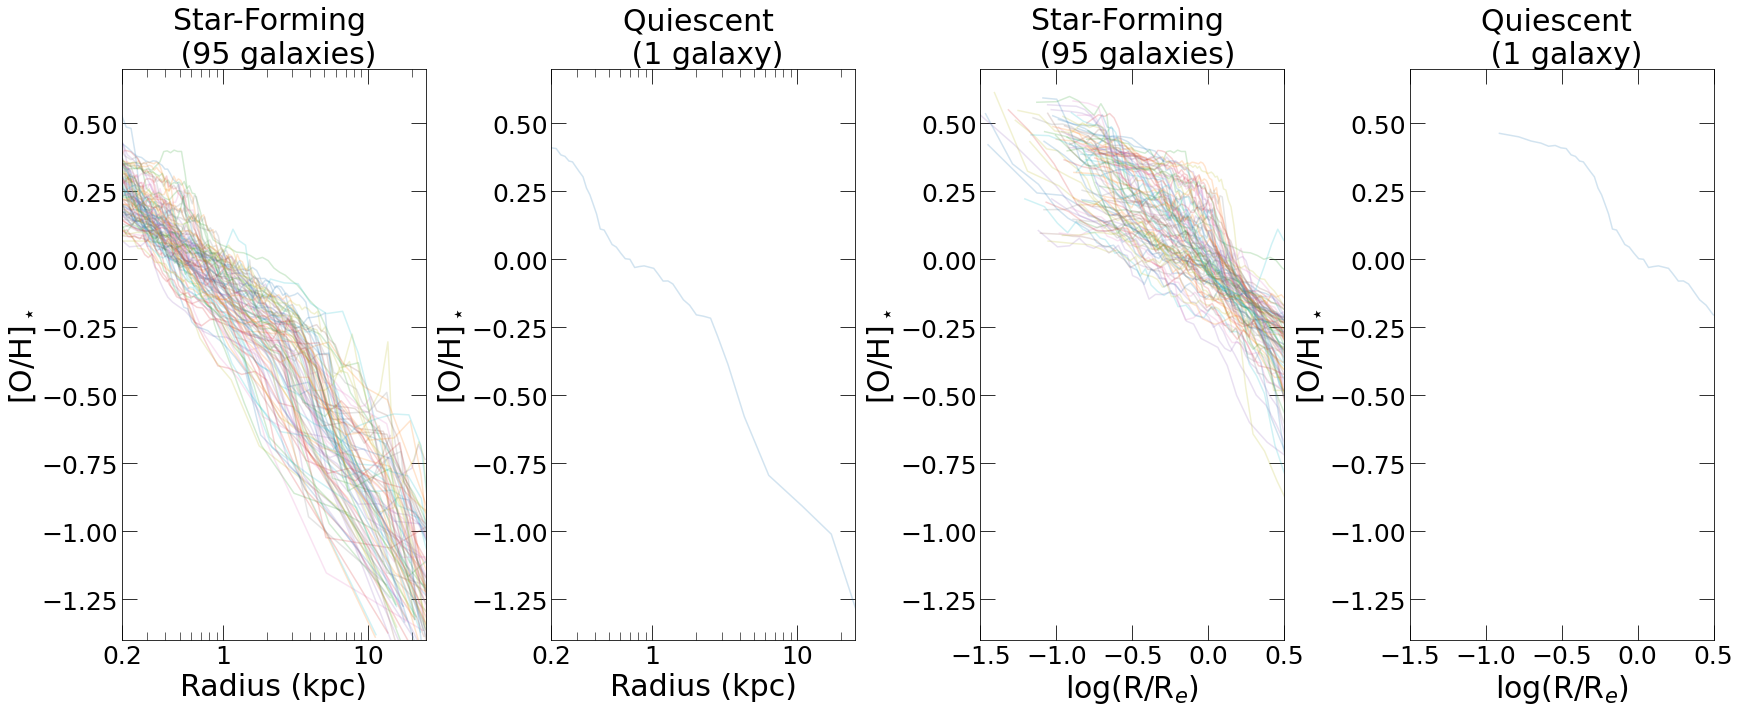

In [13]:
#metallicity profiles
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='none', sharey='none', figsize=(24, 10))
f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25

#z=2 star-forming galaxies
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[starforming_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen')
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax1.plot(xx, yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
# radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
ax1.set_xlim(0.2, 25)
ax1.set_ylim(-1.4, 0.7)
ax1.set_xlabel("Radius (kpc)", fontsize=fts)
ax1.set_ylabel('[O/H]$_\star$', fontsize=fts)
ax1.set_xscale('log')
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_xticks([0.2, 1, 10], minor=False)
ax1.set_xticklabels(['0.2', '1', '10'])

#z=2 young quiescent galaxies
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[quiescent_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen')
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax2.plot(xx, yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
ax2.set_title('Quiescent \n ('+str(len(ids[quiescent_selection]))+' galaxy)', fontsize=fts)
ax2.set_xlim(0.2, 25)
ax2.set_ylim(-1.4, 0.7)
ax2.set_xlabel("Radius (kpc)", fontsize=fts)
ax2.set_ylabel('[O/H]$_\star$', fontsize=fts)
ax2.set_xscale('log')
ax2.tick_params(which='major', length=15)
ax2.tick_params(which='minor', length=8)
ax2.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_xticks([0.2, 1, 10], minor=False)
ax2.set_xticklabels(['0.2', '1', '10'])

#effective radius star-forming
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[starforming_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen')
    Re = halfmass_radius[ids==id]
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax3.plot(np.log10(xx/Re), yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
# radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
ax3.set_xlim(-1.5, 0.5)
ax3.set_ylim(-1.4, 0.7)
ax3.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax3.set_ylabel('[O/H]$_\star$', fontsize=fts)
ax3.tick_params(which='major', length=15)
ax3.tick_params(which='minor', length=8)
ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

#effective radius quiescent
# distance = np.zeros(0)
# big_metallicity = np.zeros(0)
for id in ids[quiescent_selection]:
    yy, metallicity, xx, R = metals_profile(id=id, redshift=redshift, n_bins=n_bins, num='oxygen', den='hydrogen')
    Re = halfmass_radius[ids==id]
#     big_metallicity = np.concatenate((big_metallicity, metallicity), axis = None)
    ax4.plot(np.log10(xx/Re), yy, alpha = 0.2)
#     distance = np.concatenate((distance, R), axis = None)
# radial_percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
ax4.set_title('Quiescent \n ('+str(len(ids[quiescent_selection]))+' galaxy)', fontsize=fts) #
ax4.set_xlim(-1.5, 0.5)
ax4.set_ylim(-1.4, 0.7)
ax4.set_xlabel("log(R/R$_e$)", fontsize=fts)
ax4.set_ylabel('[O/H]$_\star$', fontsize=fts)
ax4.tick_params(which='major', length=15)
ax4.tick_params(which='minor', length=8)
ax4.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

f.tight_layout()

# plt.savefig('2022 FIGURES\profilesOH.png', dpi=100)

# gas consumption

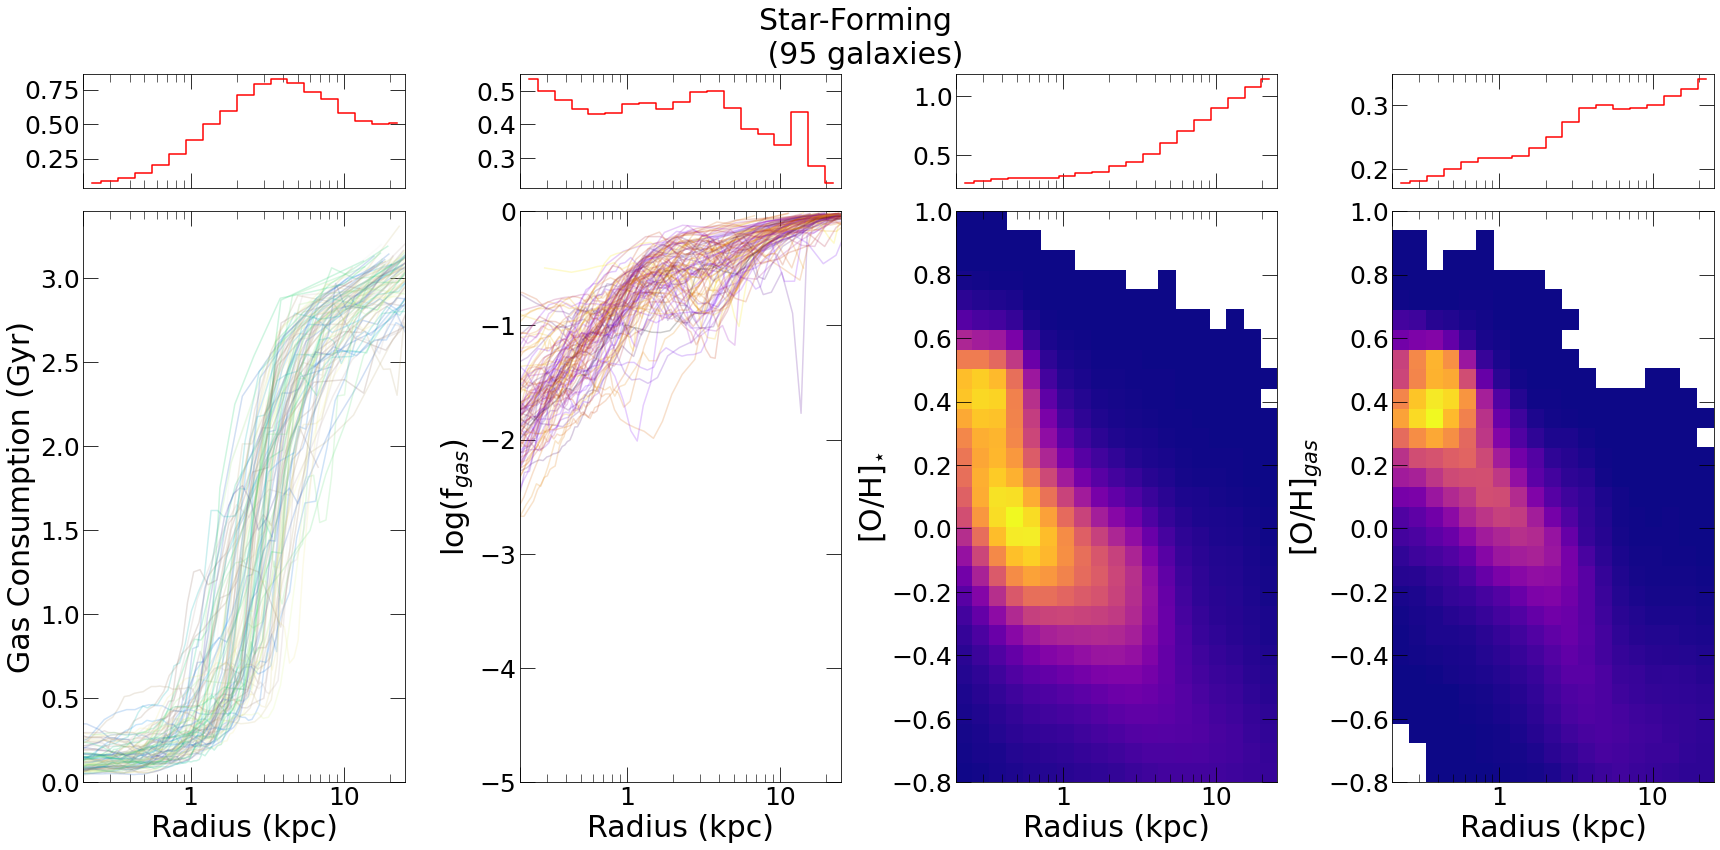

In [5]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange

#metallicity profiles
f, (axes) = plt.subplots(2, 4, sharex='none', sharey='none', figsize=(24, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
ax4 = axes[1][3]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]
sc4 = axes[0][3]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap1 = plt.get_cmap('terrain')
colormap2 = plt.get_cmap('gnuplot')
norm = colors.Normalize(vmin=0, vmax=30)
colormap = plt.get_cmap('plasma')
norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-0.8, 1, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_gas = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_star = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in ids[starforming_selection]:
    R, f_gas, _, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:
        pass
    else:
        gas_con, _ = gas_consumption(id=id, redshift=redshift, follow_stars=True)
        OH_star = starmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen')
        OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
#         R_e = halfmass_rad_stars(id, redshift)
        big_gas = np.concatenate((big_gas, gas_con*10**-9), axis=None)
        big_R = np.concatenate((big_R, R), axis=None)
        big_R_star = np.concatenate((big_R_star, R_star), axis=None)
        big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
        big_OH_star = np.concatenate((big_OH_star, OH_star), axis=None)
        big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
        h3, _, _ = np.histogram2d(R_star, OH_star, bins=[xbins, metalbins], density=False)
        big_h3 += h3
        h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
        big_h4 += h4

        # calculate statistic for profile
        n_bins = 50
        percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
        for i in range(1, (n_bins+1)):
            percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
        percentiles.sort()
        stat1, _, _ = scipy.stats.binned_statistic(R_star, gas_con*10**-9, 'median', bins=percentiles)
        stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
        xx = percentiles[:-1]
        
        number = randrange(30)
        color1 = colormap1(norm(number))
#         color1 = tuple(color1[0][:])
        color2 = colormap2(norm(number))
#         color2 = tuple(color2[0][:])
        ax1.plot(xx[1:], stat1[1:], color=color1, alpha = 0.2)
        ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_gas, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_star, big_OH_star, 'std', bins=xbins)
stat4, _, _ = stats.binned_statistic(big_R_star, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')
sc4.step(xbins_new, stat4, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 3.4)
# ax1.set_yscale('log')
ax1.set_ylabel("Gas Consumption (Gyr)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm_plasma(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 25)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10], minor=False)
    ax[2].set_xticklabels(['', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{\star}$', fontsize=fts)
ax3.set_ylim(-0.8, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

big_h4[big_h4==0] = np.nan
color=colormap(norm_plasma(big_h4)).tolist()
color = tuple(color[0][:])
ax4.pcolormesh(xbins, metalbins, big_h4.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[3].set_xlim(0.2, 25)
    ax[3].set_xscale('log')
    ax[3].set_xticks([0.2, 1, 10], minor=False)
    ax[3].set_xticklabels(['', '1', '10'])
    ax[3].tick_params(which='major', length=15)
    ax[3].tick_params(which='minor', length=8)
    ax[3].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel("Radius (kpc)", fontsize=fts)
ax4.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax4.set_ylim(-0.8, 1)

f.suptitle('Star-Forming \n (' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff.png', dpi=100)

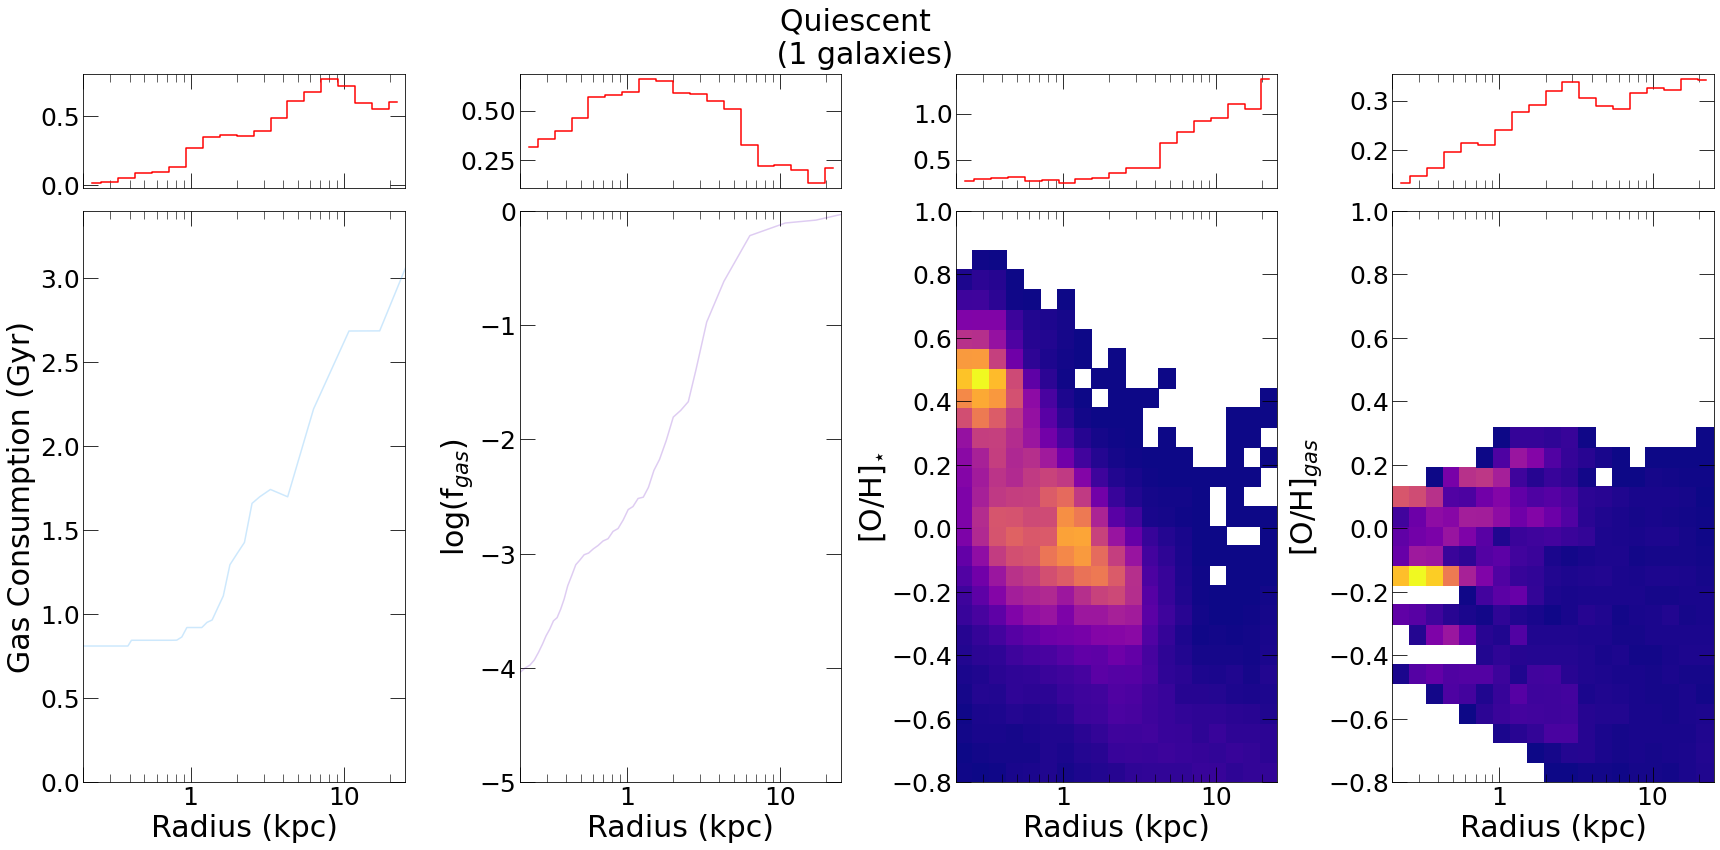

In [4]:
from matplotlib import colors
from scipy import stats
from scipy.stats import norm as normie
from random import randrange

#metallicity profiles
f, (axes) = plt.subplots(2, 4, sharex='none', sharey='none', figsize=(24, 12), gridspec_kw={'height_ratios': [1, 5]}, constrained_layout=True)
ax1 = axes[1][0]
ax2 = axes[1][1]
ax3 = axes[1][2]
ax4 = axes[1][3]
sc1 = axes[0][0]
sc2 = axes[0][1]
sc3 = axes[0][2]
sc4 = axes[0][3]

f.set_facecolor('w')
n_bins = 50
fts = 30
ftss = 25
vmin = 1.0

colormap1 = plt.get_cmap('terrain')
colormap2 = plt.get_cmap('gnuplot')
norm = colors.Normalize(vmin=0, vmax=30)
colormap = plt.get_cmap('plasma')
norm_plasma = colors.Normalize(vmin=vmin, vmax=230)

# xbins = np.linspace(-0.52, 1.94, 20)
xbins = np.logspace(np.log10(0.2), np.log10(25), 20)
ybins = np.linspace(0, 1, 30)
# yeffbins = np.logspace(np.log10(1e-8), np.log10(1e-1), 30)
metalbins = np.linspace(-0.8, 1, 30)
densitybins2 = np.linspace(1.5, 12, 20)

np.random.seed(0)

#z=2 star-forming galaxies
# big_h = np.zeros((len(xbins)-1, len(yeffbins)-1))
# big_h2 = np.zeros((len(xbins)-1, len(ybins)-1))
big_h3 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_h4 = np.zeros((len(xbins)-1, len(metalbins)-1))
big_gas = np.zeros(0)
big_R = np.zeros(0)
big_R_star = np.zeros(0)
big_f_gas = np.zeros(0)
big_OH_star = np.zeros(0)
big_OH_gas = np.zeros(0)
for id in ids[quiescent_selection]:
#     print(id)
    R, f_gas, _, R_star = effective_yield(id=id, redshift=redshift, follow_stars=True)
    if type(R) == int:# or id == 44673:
        pass
    else:
        gas_con, _ = gas_consumption(id=id, redshift=redshift, follow_stars=True)
        if type(gas_con) == int:
            pass
        else:
            OH_star = starmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen')
            OH_gas = gasmetals_only(id=id, redshift=redshift, num='oxygen', den='hydrogen', solar_units=True, follow_star=True)
    #         R_e = halfmass_rad_stars(id, redshift)
            big_gas = np.concatenate((big_gas, gas_con*10**-9), axis=None)
            big_R = np.concatenate((big_R, R), axis=None)
            big_R_star = np.concatenate((big_R_star, R_star), axis=None)
            big_f_gas = np.concatenate((big_f_gas, np.log10(f_gas)), axis=None)
            big_OH_star = np.concatenate((big_OH_star, OH_star), axis=None)
            big_OH_gas = np.concatenate((big_OH_gas, OH_gas), axis=None)
            h3, _, _ = np.histogram2d(R_star, OH_star, bins=[xbins, metalbins], density=False)
            big_h3 += h3
            h4, _, _ = np.histogram2d(R_star, OH_gas, bins=[xbins, metalbins], density=False)
            big_h4 += h4

            # calculate statistic for profile
            n_bins = 50
            percentiles = np.zeros(n_bins + 1) #N+1 for N percentiles 
            for i in range(1, (n_bins+1)):
                percentiles[i] = np.percentile(R_star, (100/n_bins)*i)
            percentiles.sort()
#             print(R_star)
#             print(gas_con*10**-9)
            stat1, _, _ = scipy.stats.binned_statistic(R_star, gas_con*10**-9, 'median', bins=percentiles)
            stat2, _, _ = scipy.stats.binned_statistic(R_star, np.log10(f_gas), 'median', bins=percentiles)
            xx = percentiles[:-1]

            number = randrange(30)
            color1 = colormap1(norm(number))
    #         color1 = tuple(color1[0][:])
            color2 = colormap2(norm(number))
    #         color2 = tuple(color2[0][:])
            ax1.plot(xx[3:], stat1[3:], color=color1, alpha = 0.2)
            ax2.plot(xx[1:], stat2[1:], color=color2, alpha = 0.2)

# quantify scatter
xbins_new = (xbins[1:]+xbins[:-1])/2
# densitybins2_new = (densitybins2[1:]+densitybins2[:-1])/2
# ybins_new = (ybins[1:]+ybins[:-1])/2
# yeffbins_new = (yeffbins[1:]+yeffbins[:-1])/2
# metalbins_new = (metalbins[1:]+metalbins[:-1])/2

stat1, _, _ = stats.binned_statistic(big_R_star, big_gas, 'std', bins=xbins)
stat2, _, _ = stats.binned_statistic(big_R_star, big_f_gas, 'std', bins=xbins)
stat3, _, _ = stats.binned_statistic(big_R_star, big_OH_star, 'std', bins=xbins)
stat4, _, _ = stats.binned_statistic(big_R_star, big_OH_gas, 'std', bins=xbins)

sc1.step(xbins_new, stat1, 'r', where='mid')
sc2.step(xbins_new, stat2, 'r', where='mid')
sc3.step(xbins_new, stat3, 'r', where='mid')
sc4.step(xbins_new, stat4, 'r', where='mid')

# plot big pixel maps
# big_h[big_h==0] = np.nan
# color=colormap(norm(big_h)).tolist()
# color = tuple(color[0][:])
# ax1.pcolormesh(xbins, ybins, big_h.T, cmap='plasma', color=color, edgecolor=None)
# ax1.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[0].set_xlim(0.2, 25)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.2, 1, 10], minor=False)
    ax[0].set_xticklabels(['', '1', '10'])
    ax[0].tick_params(which='major', length=15)
    ax[0].tick_params(which='minor', length=8)
    ax[0].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax1.set_ylim(0, 3.4)
# ax1.set_yscale('log')
ax1.set_ylabel("Gas Consumption (Gyr)", fontsize=fts)
ax1.set_xlabel('Radius (kpc)', fontsize=fts)

# big_h2[big_h2==0] = np.nan
# color=colormap(norm(big_h2)).tolist()
# color = tuple(color[0][:])
# ax2.pcolormesh(xbins, ybins, big_h2.T, cmap='plasma', color=color, edgecolor=None)
for ax in axes:
    ax[1].set_xlim(0.2, 25)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.2, 1, 10], minor=False)
    ax[1].set_xticklabels(['', '1', '10'])
    ax[1].tick_params(which='major', length=15)
    ax[1].tick_params(which='minor', length=8)
    ax[1].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax2.set_ylim(-5, 0)
ax2.set_ylabel("log(f$_{gas}$)", fontsize=fts)
ax2.set_xlabel('Radius (kpc)', fontsize=fts)

big_h3[big_h3==0] = np.nan
color=colormap(norm_plasma(big_h3)).tolist()
color = tuple(color[0][:])
ax3.pcolormesh(xbins, metalbins, big_h3.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[2].set_xlim(0.2, 25)
    ax[2].set_xscale('log')
    ax[2].set_xticks([0.2, 1, 10], minor=False)
    ax[2].set_xticklabels(['', '1', '10'])
    ax[2].tick_params(which='major', length=15)
    ax[2].tick_params(which='minor', length=8)
    ax[2].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax3.set_xlabel("Radius (kpc)", fontsize=fts)
ax3.set_ylabel('[O/H]$_{\star}$', fontsize=fts)
ax3.set_ylim(-0.8, 1)
# ax3.set_xscale('log')
# ax3.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

big_h4[big_h4==0] = np.nan
color=colormap(norm_plasma(big_h4)).tolist()
color = tuple(color[0][:])
ax4.pcolormesh(xbins, metalbins, big_h4.T, cmap='plasma', color=color, edgecolor=None)
# ax3.set_title('Star-Forming \n ('+str(len(ids[starforming_selection]))+' galaxies)', fontsize=fts) #
for ax in axes:
    ax[3].set_xlim(0.2, 25)
    ax[3].set_xscale('log')
    ax[3].set_xticks([0.2, 1, 10], minor=False)
    ax[3].set_xticklabels(['', '1', '10'])
    ax[3].tick_params(which='major', length=15)
    ax[3].tick_params(which='minor', length=8)
    ax[3].tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel("Radius (kpc)", fontsize=fts)
ax4.set_ylabel('[O/H]$_{gas}$', fontsize=fts)
ax4.set_ylim(-0.8, 1)

f.suptitle('Quiescent \n (' + str(len(ids[quiescent_selection])) + ' galaxies)', fontsize=fts)
# sc2.set_title('Star-Forming \n (90/' + str(len(ids[starforming_selection])) + ' galaxies)', fontsize=fts)

for ax in axes[0]:
    ax.set_xticklabels([])

f.tight_layout()

# plt.savefig('2022 FIGURES\yeff.png', dpi=100)